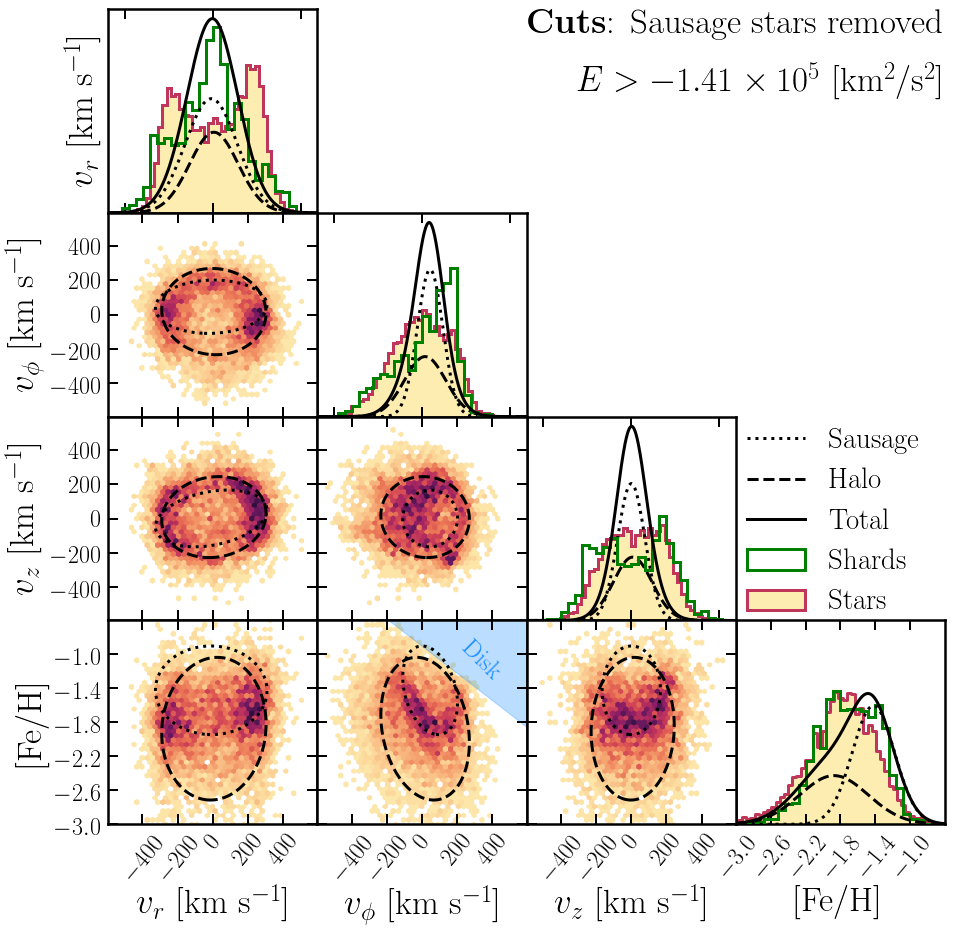

In [534]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas
import cmocean
from scipy.stats import gaussian_kde
from copy import copy

# Load data
df = pandas.read_csv('../data/Gaia-SDSS.csv')
df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df_S.group_id.unique()
# Fit
means_init = zeros(shape=(2,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-1.95]) # Halo
covariance_type = 'full'
data = array([df.GalRVel,df.GalphiVel,df.GalzVel,df.feh]).T
clf = mixture.GaussianMixture(n_components=2, covariance_type=covariance_type,means_init=means_init)
clf.fit(data)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
if covariance_type=='diag':
    covs_diag = clf.covariances_
    covs = zeros(shape=(2,4,4))
    covs = zeros(shape=(2,4,4))
    covs[0,:,:] = diag(covs_diag[0,:])
    covs[1,:,:] = diag(covs_diag[1,:])
betas = 1 - (covs[:,1,1]+covs[:,2,2])/(2*covs[:,0,0])
labs = ['Halo','Halo']
lstys = ['--','--']
lstys[argmax(betas)] = ':'
labs[argmax(betas)] = 'Sausage'


# No cuts:
# dfc = df.loc[:]
# pltname = 'fv-feh2D'
# txt = array([r'{\bf Cut}: None'])
# nbins_1D = 50
# nbins_2D = 40
# fehnorm = 1.0

#Radial action/energy cut
# cut = (df.E/1.0e5)>((df.JR/5000)**(1.0/3.0)-1.8)
# dfc = df.loc[cut]
# pltname = 'fv-feh2D-ractioncut'
# txt = array([r'{\bf Cut}: $E>\left(\frac{J_R}{5000}\right)^{1/3} - 1.9\times10^5$ km$^2$ s$^{-2}$'])
# nbins_1D = 50
# nbins_2D = 40
# fehnorm = 1.0

# dfc = df.loc[(df['E'] > -1.37e5)]
# pltname = 'fv-feh2D-wmetallicitycut'
# txt = array([r'{\bf Cuts}: $E>-1.37\times 10^5$ [km$^2$/s$^2$]', '[Fe/H]$<-2.0$'])
# nbins_1D = 30
# nbins_2D = 30
# dfc1 = df.loc[df['feh'] < -1.9]
# fehnorm = (shape(dfc)[0])/(1.0*shape(dfc1)[0])


# Sausage cut
Ps = clf.predict_proba(data)
saus_mask = Ps[:,1]<Ps[:,0]
cut = (~(Ps[:,0]>0.75))&(df['E'] > -1.41e5)
dfc = df.loc[cut]
pltname = 'fv-feh2D-sausagecut'
txt = array([r'{\bf Cuts}: Sausage stars removed',r'$E>-1.41\times 10^5$ [km$^2$/s$^2$]'])
nbins_1D = 50
nbins_2D = 40
fehnorm = 1.0



#######

# Data
vx = dfc.GalRVel
vy = dfc.GalphiVel
vz = dfc.GalzVel
feh = dfc.feh

vxS = df_S.GalRVel
vyS = df_S.GalTVel
vzS = df_S.GalzVel
fehS = df_S.feh

col_edge = col_ex[5,:]
col_face = col_ex[0,:]

cmap = copy(plt.get_cmap(cmap))
cmap.set_under('white', 1.0)

# INPUT PLOT
vmin=-595.0
vmax=595.0
nfine=500
#levels=[-6.2,-2.3,0]
levels = [-2.3,0]
tit_fontsize=30
col_an = 'k'
point_size = 8
lblsize = 31
xlblsize = 35
def_alph = 0.2
col_shards = 'green'
cmap = cmocean.cm.matter
col_ex = (cmocean.cm.matter(linspace(0,1,10)))

fehmin = -3.0
fehmax = -0.6
vfine = linspace(vmin,vmax,nfine)
fehfine = linspace(fehmin,fehmax,nfine)
V1,V2 = meshgrid(vfine,vfine)

VF1,FEH = meshgrid(vfine,fehfine)

feh_iso = -1.95735765
feh_saus = -1.40462827

v0 = SHMpp.RotationSpeed
v_esc = SHMpp.EscapeSpeed
sig_beta = append(SHMpp.SausageDispersionTensor,0.22971878)
sig_iso = append(array([1.0,1.0,1.0])*v0/sqrt(2.0),0.34086902)

def fv_1D_an(covs,meens,ws,vfine,clf,i):
    fv = zeros(shape=shape(vfine))
    if ndim(covs)>2:
        nm = shape(covs)[0]
    else:
        nm = 1
        
    for k in range(0,shape(covs)[0]):
        if nm>1:
            U = squeeze(linalg.inv(covs[k,:,:]))
            v0 = meens[k,i]
            w0 = ws[k]
        else:
            U = squeeze(linalg.inv(covs[:,:]))
            v0 = meens[i]
            w0 = ws          
        U0 = U[i,i]
        V = U[i,:]    
        V = delete(V, i, axis=0)
        W = delete(U, i, axis=0)
        W = delete(W, i, axis=1)
        U = U0 - linalg.multi_dot([V, linalg.inv(W), V.T])
        fv += w0*exp(-0.5*(vfine-v0)*U*(vfine-v0))
    fv /= trapz(fv,vfine)
    return fv


def fv_2D_an(covs,meens,ws,V1,V2,clf,i,j):
    fv = zeros(shape=shape(V1))
    if ndim(covs)>2:
        nm = shape(covs)[0]
    else:
        nm = 1
    for k in range(0,nm): 
        if nm>1:
            U = squeeze(linalg.inv(covs[k,:,:]))
            v10 = meens[k,i]
            v20 = meens[k,j]
            w0 = ws[k]
        else:
            U = squeeze(linalg.inv(covs[:,:]))
            v10 = meens[i]
            v20 = meens[j]
            w0 = ws
        U0 = array([[U[i,i],U[i,j]],[U[j,i],U[j,j]]])
        V = vstack((U[i,:],U[j,:]))    
        V = delete(V, (i,j), axis=1)

        W = delete(U, (i,j), axis=0)
        W = delete(W, (i,j), axis=1)
        Uoff = linalg.multi_dot([V, linalg.inv(W), V.T])
        Ut = U0-Uoff
        V1o = V1-v10
        V2o = V2-v20
        Norm = 1.0
        fv += w0*Norm*exp(-0.5*(V1o**2.0*Ut[0,0]+V2o**2.0*Ut[1,1]+2*V1o*V2o*Ut[1,0]))  
    fv = log(fv)
    fv = fv-amax(fv)
    return fv



# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axarr = plt.subplots(4, 4,figsize=(15,15))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.0,hspace=0.0)
ax_x = plt.subplot(gs[0,0])
ax_y = plt.subplot(gs[1,1])
ax_z = plt.subplot(gs[2,2])
ax_feh = plt.subplot(gs[3,3])

ax_yx = plt.subplot(gs[1,0])
ax_zx = plt.subplot(gs[2,0])
ax_zy = plt.subplot(gs[2,1])
ax_xfeh = plt.subplot(gs[3,0])
ax_yfeh = plt.subplot(gs[3,1])
ax_zfeh = plt.subplot(gs[3,2])

fig.delaxes(plt.subplot(gs[0,1]))
fig.delaxes(plt.subplot(gs[0,2]))
fig.delaxes(plt.subplot(gs[0,3]))
fig.delaxes(plt.subplot(gs[1,2]))
fig.delaxes(plt.subplot(gs[1,3]))
fig.delaxes(plt.subplot(gs[2,3]))

# 1D plots
ax_x.plot(vfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],vfine,clf,0),linestyle=lstys[0],linewidth=3,color=col_an,zorder=5)
ax_x.plot(vfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],vfine,clf,0),linestyle=lstys[1],linewidth=3,color=col_an,zorder=5)
ax_x.plot(vfine,fv_1D_an(covs,meens,ws,vfine,clf,0),'-',linewidth=3,color=col_an,zorder=5)
ax_x.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_face,linewidth=3,normed=1,label=None)
ax_x.hist(vxS,range=[vmin,vmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label=None,zorder=5)
ax_x.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_edge,linewidth=3,histtype='step',normed=1,label=None)
ax_x.fill_between([-900,-900],[0.0001,0.0001],lw=3,edgecolor=col_edge,facecolor=col_face,label=None)
ax_x.set_ylabel(r'$v_r$ [km s$^{-1}$]',fontsize=xlblsize)

ax_y.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_face,linewidth=3,normed=1)
ax_y.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_edge,linewidth=3,histtype='step',normed=1)
ax_y.hist(vyS,range=[vmin,vmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label='Shards',zorder=5)
ax_y.plot(vfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],vfine,clf,1),linestyle=lstys[0],linewidth=3,color=col_an)
ax_y.plot(vfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],vfine,clf,1),linestyle=lstys[1],linewidth=3,color=col_an)
ax_y.plot(vfine,fv_1D_an(covs,meens,ws,vfine,clf,1),'-',linewidth=3,color=col_an,zorder=5)


ax_z.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_face,linewidth=3,normed=1)
ax_z.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_edge,linewidth=3,histtype='step',normed=1)
ax_z.hist(vzS,range=[vmin,vmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label='Shards',zorder=5)
ax_z.plot(vfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],vfine,clf,2),linestyle=lstys[0],linewidth=3,color=col_an)
ax_z.plot(vfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],vfine,clf,2),linestyle=lstys[1],linewidth=3,color=col_an)
ax_z.plot(vfine,fv_1D_an(covs,meens,ws,vfine,clf,2),'-',linewidth=3,color=col_an,zorder=5)


feh_hist,fehv = histogram(feh,range=[fehmin,fehmax],bins=nbins_1D,normed=1)
feh0 = (fehv[1:]+fehv[0:-1])/2.0
ax_feh.fill_between(feh0,feh_hist*fehnorm,color=col_face,label=None,step='pre')
ax_feh.step(feh0,feh_hist*fehnorm,color=col_edge,linewidth=3,label=None)
ax_feh.hist(fehS,range=[fehmin,fehmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label='Shards',zorder=5)
#ax_feh.plot(1000*fehfine,fv_1D_an(fehfine-feh_iso,sig_iso,3),'-',linewidth=3,color=col_an,label=r'SHM$^{++}$',zorder=0)
ax_feh.plot(fehfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],fehfine,clf,3),linestyle=lstys[0],linewidth=3,color=col_an,label=labs[0],zorder=5)
ax_feh.plot(fehfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],fehfine,clf,3),linestyle=lstys[1],linewidth=3,color=col_an,label=labs[1],zorder=5)
ax_feh.plot(fehfine,fv_1D_an(covs,meens,ws,fehfine,clf,3),'-',linewidth=3,color=col_an,zorder=5,label='Total')
ax_feh.fill_between(1000*feh[0:1],1000*feh[0:1],y2=-100.0,facecolor=col_face,edgecolor=col_edge,lw=3,label='Stars')
ax_feh.legend(fontsize=lblsize-2,frameon=False,bbox_to_anchor=(0.0, 2.0), loc=2, borderaxespad=0.)


# 2D plots
ax_yx.hexbin(vx,vy,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yx.hexbin(vx,vy,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yx.hexbin(vx,vy,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yx.contour(vfine,vfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],V1,V2,clf,0,1),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_yx.contour(vfine,vfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],V1,V2,clf,0,1),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_yx.set_ylabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=xlblsize)

ax_zx.hexbin(vx,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zx.hexbin(vx,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zx.hexbin(vx,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zx.contour(vfine,vfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],V1,V2,clf,0,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_zx.contour(vfine,vfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],V1,V2,clf,0,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_zx.set_ylabel(r'$v_z$ [km s$^{-1}$]',fontsize=xlblsize)

ax_zy.hexbin(vy,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zy.hexbin(vy,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zy.hexbin(vy,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zy.contour(vfine,vfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],V1,V2,clf,1,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_zy.contour(vfine,vfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],V1,V2,clf,1,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])

ax_xfeh.hexbin(vx,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_xfeh.hexbin(vx,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_xfeh.hexbin(vx,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_xfeh.contour(vfine,fehfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],VF1,FEH,clf,0,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_xfeh.contour(vfine,fehfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],VF1,FEH,clf,0,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])

ax_yfeh.hexbin(vy,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yfeh.hexbin(vy,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yfeh.hexbin(vy,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yfeh.contour(vfine,fehfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],VF1,FEH,clf,1,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_yfeh.contour(vfine,fehfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],VF1,FEH,clf,1,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_yfeh.fill_between(vfine,-0.0016*vfine-0.9,y2=0.0,color='dodgerblue',alpha=0.3)
ax_yfeh.text(200,-1.0,'Disk',color='dodgerblue',fontsize=25,rotation=-45)

ax_zfeh.hexbin(vz,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zfeh.hexbin(vz,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zfeh.hexbin(vz,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zfeh.contour(vfine,fehfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],VF1,FEH,clf,2,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_zfeh.contour(vfine,fehfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],VF1,FEH,clf,2,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])

vtx = array([-400,-200,0,200,400])
ftx = arange(-3.0,-0.6,0.4)
ax_xfeh.set_xticks(vtx)
ax_yfeh.set_xticks(vtx)
ax_zfeh.set_xticks(vtx)

ax_xfeh.set_yticks(ftx)
ax_yfeh.set_yticks(ftx)
ax_zfeh.set_yticks(ftx)
ax_feh.set_xticks(ftx)

ax_yx.set_xticks(vtx)
ax_zx.set_xticks(vtx)
ax_zy.set_xticks(vtx)
ax_yx.set_yticks(vtx)
ax_zx.set_yticks(vtx)
ax_zy.set_yticks(vtx)


# Tick params
ax_x.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_y.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_z.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_zx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_yx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_zy.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_xfeh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_yfeh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_zfeh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_feh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)

for i in range(0,size(txt)):
    plt.gcf().text(0.9,0.88-i*0.05,txt[i],fontsize=35,horizontalalignment='right',verticalalignment='top')


ax_yx.set_xlim([vmin,vmax])
ax_yx.set_ylim([vmin,vmax])
ax_zx.set_xlim([vmin,vmax])
ax_zx.set_ylim([vmin,vmax])
ax_zy.set_xlim([vmin,vmax])
ax_zy.set_ylim([vmin,vmax])
ax_x.set_xlim([vmin,vmax])
ax_y.set_xlim([vmin,vmax])
ax_z.set_xlim([vmin,vmax])
ax_x.set_yticks([])
ax_y.set_yticks([])
ax_z.set_yticks([])
ax_feh.set_yticks([])
ax_x.set_yticklabels([])
ax_x.set_xticklabels([])
ax_y.set_yticklabels([])
ax_y.set_xticklabels([])
ax_z.set_yticklabels([])
ax_yx.set_xticklabels([])
ax_zy.set_yticklabels([])

ax_xfeh.set_ylim([fehmin,fehmax])
ax_yfeh.set_ylim([fehmin,fehmax])
ax_zfeh.set_ylim([fehmin,fehmax])
ax_yfeh.set_yticklabels([])
ax_zfeh.set_yticklabels([])

ax_feh.set_xlim([fehmin,fehmax])
ax_feh.set_ylim(bottom=0.0,top=1.7)
ax_xfeh.set_xlim([vmin,vmax])
ax_yfeh.set_xlim([vmin,vmax])
ax_zfeh.set_xlim([vmin,vmax])

ax_xfeh.set_ylabel(r'[Fe/H]',fontsize=xlblsize)
ax_xfeh.set_xlabel(r'$v_r$ [km s$^{-1}$]',fontsize=xlblsize)
ax_yfeh.set_xlabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=xlblsize)
ax_zfeh.set_xlabel(r'$v_z$ [km s$^{-1}$]',fontsize=xlblsize)
ax_feh.set_xlabel(r'[Fe/H]',fontsize=xlblsize)



plt.sca(ax_feh)
plt.xticks(rotation=50)
plt.sca(ax_xfeh)
plt.xticks(rotation=50)
plt.sca(ax_yfeh)
plt.xticks(rotation=50)
plt.sca(ax_zfeh)
plt.xticks(rotation=50)


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

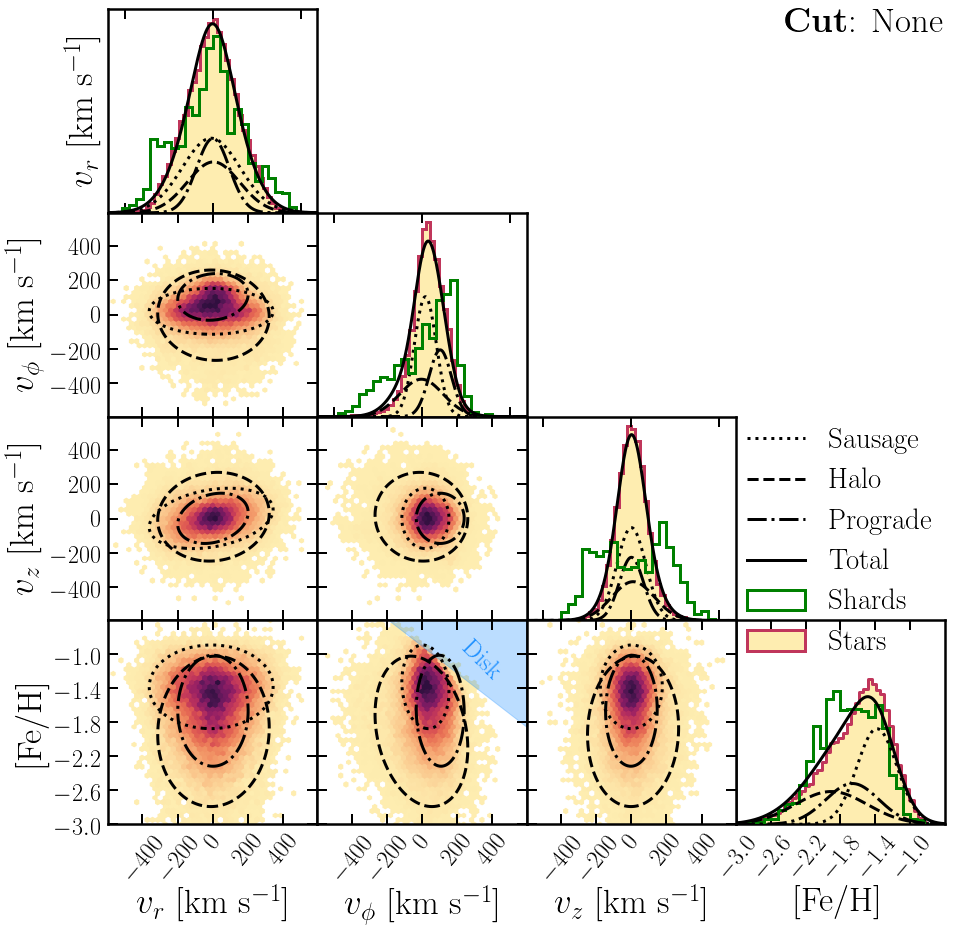

In [535]:
# Fit
means_init = zeros(shape=(3,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-1.95]) # Halo
means_init[2,:] = array([0.0,100.0,0.0,-1.8]) # Halo
covariance_type = 'full'
data = array([df.GalRVel,df.GalphiVel,df.GalzVel,df.feh]).T
clf = mixture.GaussianMixture(n_components=3, covariance_type=covariance_type,means_init=means_init)
clf.fit(data)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
if covariance_type=='diag':
    covs_diag = clf.covariances_
    covs = zeros(shape=(2,4,4))
    covs = zeros(shape=(2,4,4))
    covs[0,:,:] = diag(covs_diag[0,:])
    covs[1,:,:] = diag(covs_diag[1,:])
betas = 1 - (covs[:,1,1]+covs[:,2,2])/(2*covs[:,0,0])
labs = ['Sausage','Halo','Prograde']
lstys = [':','--','-.']


#No cuts:
dfc = df.loc[:]
pltname = 'fv-feh2D_3components'
txt = array([r'{\bf Cut}: None'])
nbins_1D = 50
nbins_2D = 40
fehnorm = 1.0


# Data
vx = dfc.GalRVel
vy = dfc.GalphiVel
vz = dfc.GalzVel
feh = dfc.feh


fig, axarr = plt.subplots(4, 4,figsize=(15,15))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.0,hspace=0.0)
ax_x = plt.subplot(gs[0,0])
ax_y = plt.subplot(gs[1,1])
ax_z = plt.subplot(gs[2,2])
ax_feh = plt.subplot(gs[3,3])

ax_yx = plt.subplot(gs[1,0])
ax_zx = plt.subplot(gs[2,0])
ax_zy = plt.subplot(gs[2,1])
ax_xfeh = plt.subplot(gs[3,0])
ax_yfeh = plt.subplot(gs[3,1])
ax_zfeh = plt.subplot(gs[3,2])

fig.delaxes(plt.subplot(gs[0,1]))
fig.delaxes(plt.subplot(gs[0,2]))
fig.delaxes(plt.subplot(gs[0,3]))
fig.delaxes(plt.subplot(gs[1,2]))
fig.delaxes(plt.subplot(gs[1,3]))
fig.delaxes(plt.subplot(gs[2,3]))

# 1D plots
ax_x.plot(vfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],vfine,clf,0),linestyle=lstys[0],linewidth=3,color=col_an,zorder=5)
ax_x.plot(vfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],vfine,clf,0),linestyle=lstys[1],linewidth=3,color=col_an,zorder=5)
ax_x.plot(vfine,ws[2]*fv_1D_an(covs[2,:,:],meens[2,:],ws[2],vfine,clf,0),linestyle=lstys[2],linewidth=3,color=col_an,zorder=5)
ax_x.plot(vfine,fv_1D_an(covs,meens,ws,vfine,clf,0),'-',linewidth=3,color=col_an,zorder=5)
ax_x.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_face,linewidth=3,normed=1,label=None)
ax_x.hist(vxS,range=[vmin,vmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label=None,zorder=5)
ax_x.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_edge,linewidth=3,histtype='step',normed=1,label=None)
ax_x.fill_between([-900,-900],[0.0001,0.0001],lw=3,edgecolor=col_edge,facecolor=col_face,label=None)
ax_x.set_ylabel(r'$v_r$ [km s$^{-1}$]',fontsize=xlblsize)

ax_y.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_face,linewidth=3,normed=1)
ax_y.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_edge,linewidth=3,histtype='step',normed=1)
ax_y.hist(vyS,range=[vmin,vmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label='Shards',zorder=5)
ax_y.plot(vfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],vfine,clf,1),linestyle=lstys[0],linewidth=3,color=col_an)
ax_y.plot(vfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],vfine,clf,1),linestyle=lstys[1],linewidth=3,color=col_an)
ax_y.plot(vfine,ws[2]*fv_1D_an(covs[2,:,:],meens[2,:],ws[2],vfine,clf,1),linestyle=lstys[2],linewidth=3,color=col_an)
ax_y.plot(vfine,fv_1D_an(covs,meens,ws,vfine,clf,1),'-',linewidth=3,color=col_an,zorder=5)


ax_z.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_face,linewidth=3,normed=1)
ax_z.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_edge,linewidth=3,histtype='step',normed=1)
ax_z.hist(vzS,range=[vmin,vmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label='Shards',zorder=5)
ax_z.plot(vfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],vfine,clf,2),linestyle=lstys[0],linewidth=3,color=col_an)
ax_z.plot(vfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],vfine,clf,2),linestyle=lstys[1],linewidth=3,color=col_an)
ax_z.plot(vfine,ws[2]*fv_1D_an(covs[2,:,:],meens[2,:],ws[2],vfine,clf,2),linestyle=lstys[2],linewidth=3,color=col_an)
ax_z.plot(vfine,fv_1D_an(covs,meens,ws,vfine,clf,2),'-',linewidth=3,color=col_an,zorder=5)


feh_hist,fehv = histogram(feh,range=[fehmin,fehmax],bins=nbins_1D,normed=1)
feh0 = (fehv[1:]+fehv[0:-1])/2.0
ax_feh.fill_between(feh0,feh_hist*fehnorm,color=col_face,label=None,step='pre')
ax_feh.step(feh0,feh_hist*fehnorm,color=col_edge,linewidth=3,label=None)
ax_feh.hist(fehS,range=[fehmin,fehmax],bins=30,color=col_shards,linewidth=3,histtype='step',normed=1,label='Shards',zorder=5)
#ax_feh.plot(1000*fehfine,fv_1D_an(fehfine-feh_iso,sig_iso,3),'-',linewidth=3,color=col_an,label=r'SHM$^{++}$',zorder=0)
ax_feh.plot(fehfine,ws[0]*fv_1D_an(covs[0,:,:],meens[0,:],ws[0],fehfine,clf,3),linestyle=lstys[0],linewidth=3,color=col_an,label=labs[0],zorder=5)
ax_feh.plot(fehfine,ws[1]*fv_1D_an(covs[1,:,:],meens[1,:],ws[1],fehfine,clf,3),linestyle=lstys[1],linewidth=3,color=col_an,label=labs[1],zorder=5)
ax_feh.plot(fehfine,ws[2]*fv_1D_an(covs[2,:,:],meens[2,:],ws[2],fehfine,clf,3),linestyle=lstys[2],linewidth=3,color=col_an,label=labs[2],zorder=5)
ax_feh.plot(fehfine,fv_1D_an(covs,meens,ws,fehfine,clf,3),'-',linewidth=3,color=col_an,zorder=5,label='Total')
ax_feh.fill_between(1000*feh[0:1],1000*feh[0:1],y2=-100.0,facecolor=col_face,edgecolor=col_edge,lw=3,label='Stars')
ax_feh.legend(fontsize=lblsize-2,frameon=False,bbox_to_anchor=(0.0, 2.0), loc=2, borderaxespad=0.)


# 2D plots
ax_yx.hexbin(vx,vy,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yx.hexbin(vx,vy,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yx.hexbin(vx,vy,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yx.contour(vfine,vfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],V1,V2,clf,0,1),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_yx.contour(vfine,vfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],V1,V2,clf,0,1),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_yx.contour(vfine,vfine,fv_2D_an(covs[2,:,:],meens[2,:],ws[2],V1,V2,clf,0,1),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[2])
ax_yx.set_ylabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=xlblsize)

ax_zx.hexbin(vx,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zx.hexbin(vx,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zx.hexbin(vx,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zx.contour(vfine,vfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],V1,V2,clf,0,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_zx.contour(vfine,vfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],V1,V2,clf,0,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_zx.contour(vfine,vfine,fv_2D_an(covs[2,:,:],meens[2,:],ws[2],V1,V2,clf,0,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[2])
ax_zx.set_ylabel(r'$v_z$ [km s$^{-1}$]',fontsize=xlblsize)

ax_zy.hexbin(vy,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zy.hexbin(vy,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zy.hexbin(vy,vz,extent=(vmin,vmax,vmin,vmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zy.contour(vfine,vfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],V1,V2,clf,1,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_zy.contour(vfine,vfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],V1,V2,clf,1,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_zy.contour(vfine,vfine,fv_2D_an(covs[2,:,:],meens[2,:],ws[2],V1,V2,clf,1,2),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[2])

ax_xfeh.hexbin(vx,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_xfeh.hexbin(vx,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_xfeh.hexbin(vx,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_xfeh.contour(vfine,fehfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],VF1,FEH,clf,0,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_xfeh.contour(vfine,fehfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],VF1,FEH,clf,0,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_xfeh.contour(vfine,fehfine,fv_2D_an(covs[2,:,:],meens[2,:],ws[2],VF1,FEH,clf,0,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[2])

ax_yfeh.hexbin(vy,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yfeh.hexbin(vy,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yfeh.hexbin(vy,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_yfeh.contour(vfine,fehfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],VF1,FEH,clf,1,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_yfeh.contour(vfine,fehfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],VF1,FEH,clf,1,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_yfeh.contour(vfine,fehfine,fv_2D_an(covs[2,:,:],meens[2,:],ws[2],VF1,FEH,clf,1,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[2])

ax_yfeh.fill_between(vfine,-0.0016*vfine-0.9,y2=0.0,color='dodgerblue',alpha=0.3)
ax_yfeh.text(200,-1.0,'Disk',color='dodgerblue',fontsize=25,rotation=-45)

ax_zfeh.hexbin(vz,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zfeh.hexbin(vz,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zfeh.hexbin(vz,feh,extent=(vmin,vmax,fehmin,fehmax),gridsize=nbins_2D,cmap=cmap,vmin=0.001,linewidths=0.2)
ax_zfeh.contour(vfine,fehfine,fv_2D_an(covs[0,:,:],meens[0,:],ws[0],VF1,FEH,clf,2,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[0])
ax_zfeh.contour(vfine,fehfine,fv_2D_an(covs[1,:,:],meens[1,:],ws[1],VF1,FEH,clf,2,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[1])
ax_zfeh.contour(vfine,fehfine,fv_2D_an(covs[2,:,:],meens[2,:],ws[2],VF1,FEH,clf,2,3),levels=levels,colors=col_an,linewidths=3,linestyles=lstys[2])

vtx = array([-400,-200,0,200,400])
ftx = arange(-3.0,-0.6,0.4)
ax_xfeh.set_xticks(vtx)
ax_yfeh.set_xticks(vtx)
ax_zfeh.set_xticks(vtx)

ax_xfeh.set_yticks(ftx)
ax_yfeh.set_yticks(ftx)
ax_zfeh.set_yticks(ftx)
ax_feh.set_xticks(ftx)

ax_yx.set_xticks(vtx)
ax_zx.set_xticks(vtx)
ax_zy.set_xticks(vtx)
ax_yx.set_yticks(vtx)
ax_zx.set_yticks(vtx)
ax_zy.set_yticks(vtx)


# Tick params
ax_x.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_y.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_z.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_zx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_yx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_zy.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_xfeh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_yfeh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_zfeh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
ax_feh.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)

for i in range(0,size(txt)):
    plt.gcf().text(0.9,0.88-i*0.05,txt[i],fontsize=35,horizontalalignment='right',verticalalignment='top')


ax_yx.set_xlim([vmin,vmax])
ax_yx.set_ylim([vmin,vmax])
ax_zx.set_xlim([vmin,vmax])
ax_zx.set_ylim([vmin,vmax])
ax_zy.set_xlim([vmin,vmax])
ax_zy.set_ylim([vmin,vmax])
ax_x.set_xlim([vmin,vmax])
ax_y.set_xlim([vmin,vmax])
ax_z.set_xlim([vmin,vmax])
ax_x.set_yticks([])
ax_y.set_yticks([])
ax_z.set_yticks([])
ax_feh.set_yticks([])
ax_x.set_yticklabels([])
ax_x.set_xticklabels([])
ax_y.set_yticklabels([])
ax_y.set_xticklabels([])
ax_z.set_yticklabels([])
ax_yx.set_xticklabels([])
ax_zy.set_yticklabels([])

ax_xfeh.set_ylim([fehmin,fehmax])
ax_yfeh.set_ylim([fehmin,fehmax])
ax_zfeh.set_ylim([fehmin,fehmax])
ax_yfeh.set_yticklabels([])
ax_zfeh.set_yticklabels([])

ax_feh.set_xlim([fehmin,fehmax])
ax_feh.set_ylim(bottom=0.0,top=1.7)
ax_xfeh.set_xlim([vmin,vmax])
ax_yfeh.set_xlim([vmin,vmax])
ax_zfeh.set_xlim([vmin,vmax])

ax_xfeh.set_ylabel(r'[Fe/H]',fontsize=xlblsize)
ax_xfeh.set_xlabel(r'$v_r$ [km s$^{-1}$]',fontsize=xlblsize)
ax_yfeh.set_xlabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=xlblsize)
ax_zfeh.set_xlabel(r'$v_z$ [km s$^{-1}$]',fontsize=xlblsize)
ax_feh.set_xlabel(r'[Fe/H]',fontsize=xlblsize)



plt.sca(ax_feh)
plt.xticks(rotation=50)
plt.sca(ax_xfeh)
plt.xticks(rotation=50)
plt.sca(ax_yfeh)
plt.xticks(rotation=50)
plt.sca(ax_zfeh)
plt.xticks(rotation=50)


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [530]:
fehmin = -3.0
fehmax = -0.6
vfine = linspace(vmin,vmax,nfine)
fehfine = linspace(fehmin,fehmax,nfine)
V1,V2 = meshgrid(vfine,vfine)

VF1,FEH = meshgrid(vfine,fehfine)